In [1]:
from typing import cast, Dict, List, Union

import torch
from torch import Tensor
from torch import nn
from random import shuffle
import cv2
import torchvision

import os
import time
from torch import optim
import torch
from torch import nn
from torch import optim
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot


In [2]:
__all__ = [
    "VGG",
    "vgg11", "vgg13", "vgg16", "vgg19",
    "vgg11_bn", "vgg13_bn", "vgg16_bn", "vgg19_bn",
]

vgg_cfgs: Dict[str, List[Union[str, int]]] = {
    "vgg11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "vgg16": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
    "vgg19": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
}


In [3]:

def _make_layers(vgg_cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: nn.Sequential[nn.Module] = nn.Sequential()
    in_channels = 3
    for v in vgg_cfg:
        if v == "M":
            layers.append(nn.MaxPool2d((2, 2), (2, 2)))
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, (3, 3), (1, 1), (1, 1))
            if batch_norm:
                layers.append(conv2d)
                layers.append(nn.BatchNorm2d(v))
                layers.append(nn.ReLU(True))
            else:
                layers.append(conv2d)
                layers.append(nn.ReLU(True))
            in_channels = v

    return layers


class VGG(nn.Module):
    def __init__(self, vgg_cfg: List[Union[str, int]], batch_norm: bool = False, num_classes: int = 1000) -> None:
        super(VGG, self).__init__()
        self.features = _make_layers(vgg_cfg, batch_norm)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

        # Initialize neural network weights
        self._initialize_weights()
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: Tensor) -> Tensor:
        out = self.features(x)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0, 0.01)
                nn.init.constant_(module.bias, 0)


def vgg11(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], False, **kwargs)

    return model


def vgg13(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], False, **kwargs)

    return model


def vgg16(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], False, **kwargs)

    return model


def vgg19(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], False, **kwargs)

    return model


def vgg11_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg11"], True, **kwargs)

    return model


def vgg13_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg13"], True, **kwargs)

    return model


def vgg16_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg16"], True, **kwargs)

    return model


def vgg19_bn(**kwargs) -> VGG:
    model = VGG(vgg_cfgs["vgg19"], True, **kwargs)

    return model

In [4]:
# os.makedirs('./COVID19-DATASET/train/covid')
# os.makedirs('./COVID19-DATASET/train/normal')
# os.makedirs('./COVID19-DATASET/train/pneumonia')
# os.makedirs('./COVID19-DATASET/train/lung_opacity')

COVID_PATH = '/Users/mortezamalekabadi/data2/covid/'
NORMAL_PATH = '/Users/mortezamalekabadi/data2/normal/'
PNEUMONIA_PATH = '/Users/mortezamalekabadi/data2/pneumonia/'



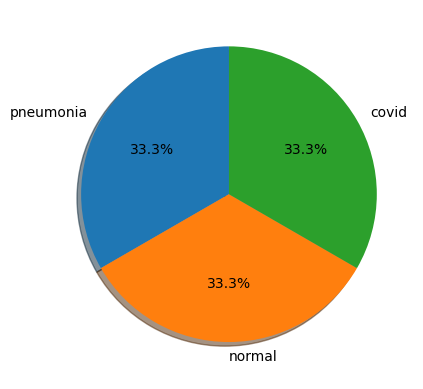

In [5]:
DATA_PATH = '/Users/mortezamalekabadi/data2'
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

In [6]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

/var/folders/f_/wy2ldffd3lg4w5hk1lr1rs7m0000gn/T/ipykernel_55966/2839204797.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


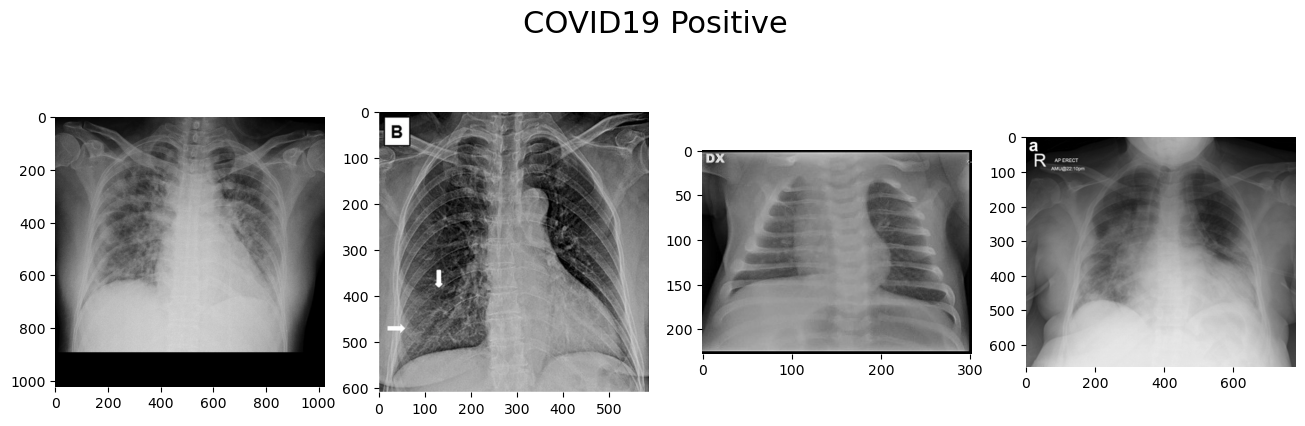

In [7]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
    # print(os.path.join(COVID_PATH, image))
fig.show()

/var/folders/f_/wy2ldffd3lg4w5hk1lr1rs7m0000gn/T/ipykernel_55966/2599686391.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


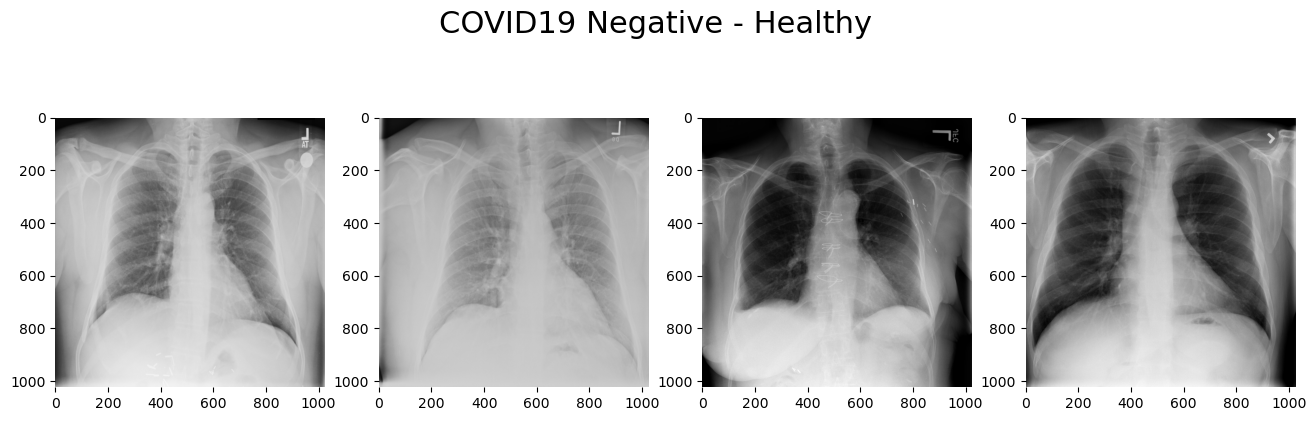

In [8]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [9]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [10]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=32) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=32)
    return trainloader, testloader, dataset_size
    
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid', 'normal', 'pneumonia']


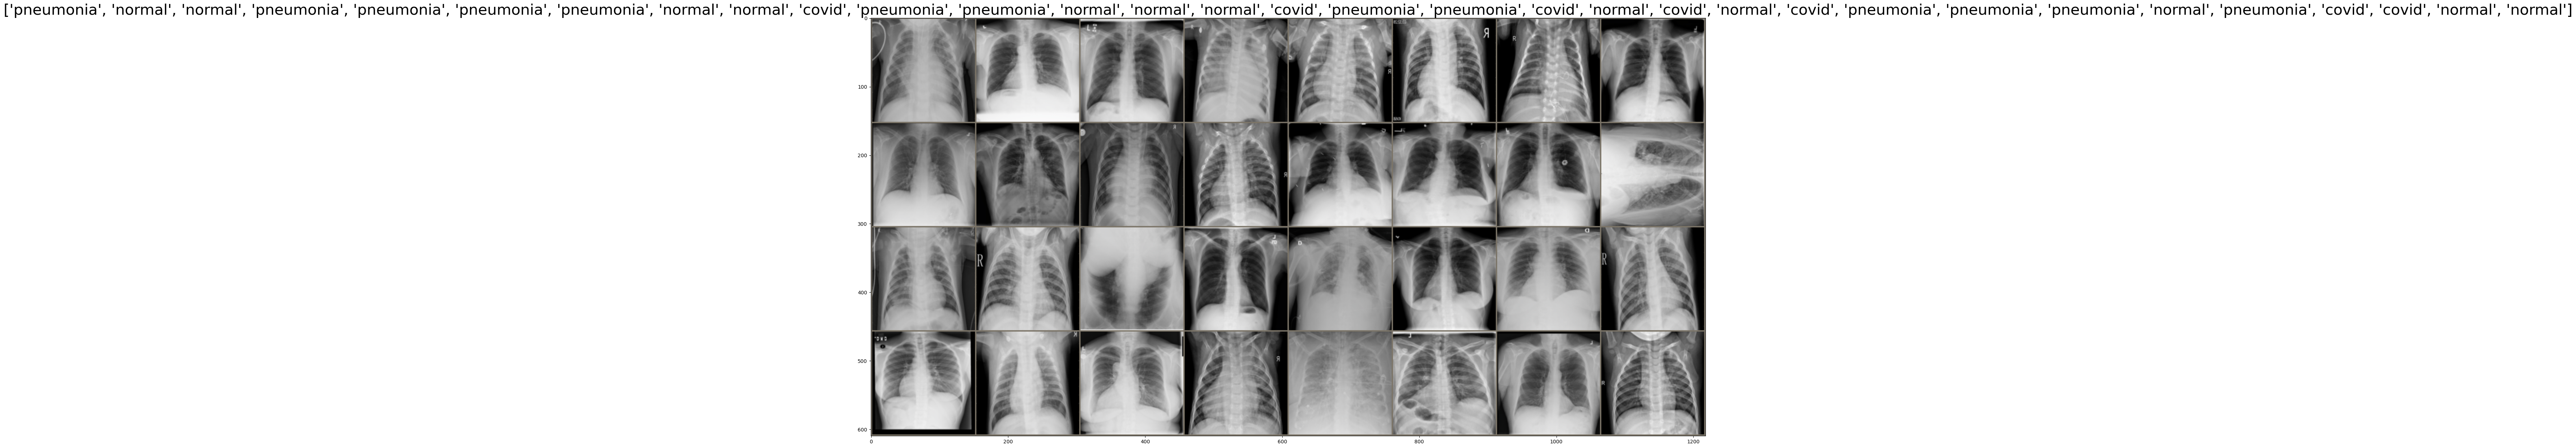

In [11]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# model = vgg11();
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16_bn', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

Using cache found in /Users/mortezamalekabadi/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/mortezamalekabadi/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mortezamalekabadi/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)
Accuracies = []
num_epochs = 10
total_steps = len(trainloader)
t1 = time.time()
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            Accuracies.append((correct / total) * 100)
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cpu
Epoch [1/10], Step [100/173], Loss: 1.2012, Accuracy: 34.38%
Epoch [2/10], Step [100/173], Loss: 1.0601, Accuracy: 46.88%
Epoch [3/10], Step [100/173], Loss: 1.1404, Accuracy: 25.00%
Epoch [4/10], Step [100/173], Loss: 1.0892, Accuracy: 31.25%
Epoch [5/10], Step [100/173], Loss: 1.0844, Accuracy: 43.75%
Epoch [6/10], Step [100/173], Loss: 1.1254, Accuracy: 37.50%
Epoch [7/10], Step [100/173], Loss: 1.1270, Accuracy: 31.25%
Epoch [8/10], Step [100/173], Loss: 1.1234, Accuracy: 21.88%
Epoch [9/10], Step [100/173], Loss: 1.1510, Accuracy: 28.12%
Epoch [10/10], Step [100/173], Loss: 1.1147, Accuracy: 31.25%
######## Training Finished in 8662.905483961105 seconds ###########


Test Accuracy of the model on the 1380 test images: 32.391304347826086 %


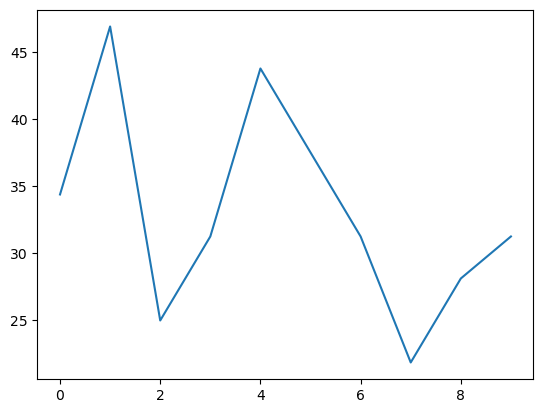

In [14]:
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))
    
plt.plot(Accuracies)